<a href="https://colab.research.google.com/github/lesi-nedo/ISPR_assignments/blob/main/assignment_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" ><b> <font face="Rage" size=7 >RBM From Scratch</font></b></div>

<div align="center" ><b> <font face="Rage" size=5 >Assignment 3</font></b></div>
<div align="center" ><b> <font face="Rage" size=4 >Oleksiy Nedobiychuk</font></b></div>


## Setup and Download the Dataset

In [1]:
import gzip
import os
from urllib.request import urlretrieve

train_img_url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
train_label_url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

current_dir = os.getcwd()
train_imgs_name_f = 'train_imgs.gz'
label_imgs_name_f = 'train_labels.gz'
train_img_path = None
train_label_path = None


def check_or_download(url, file_name):
    path = None
    if not os.path.exists(file_name):
        path, _ = urlretrieve(url, file_name)
        print(f"Downloaded {file_name}")
    else:
        pwd = os.getcwd()
        path = os.path.abspath(f"{pwd}/{file_name}")
        print(f"{file_name} already exists")
    return path


path_imgs = check_or_download(train_img_url, train_imgs_name_f)
path_labels = check_or_download(train_label_url, label_imgs_name_f)




with gzip.open(path_imgs, 'rb') as train_imgs_f:
    train_imgs = train_imgs_f.read()

with gzip.open(path_labels, 'rb') as train_labels_f:
    train_labels = train_labels_f.read()


train_imgs.gz already exists
train_labels.gz already exists


## Read the data from the file to the memory

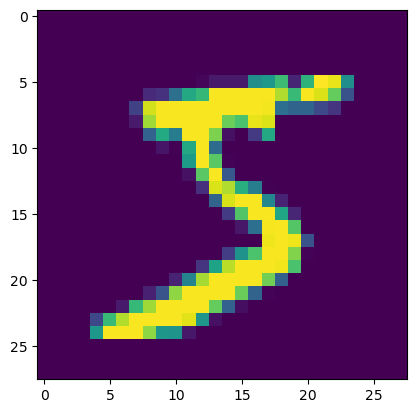

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

image_size = 28
num_images = 60000

data = np.frombuffer(train_imgs, dtype=np.uint8, count=image_size*image_size*num_images, offset=16).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

image = np.asarray(data[0]).squeeze()
plt.imshow(image)
plt.show()

## Image Binary Encoding

I employed random clamping to convert the data into a binary vector.

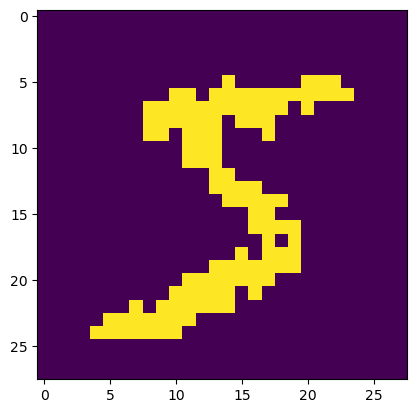

In [21]:
threshold = 30

numpy_rng = np.random.RandomState(89377)
data /= 255

rand_d = numpy_rng.rand(*data.shape)


data = (rand_d < data).astype(np.float32)

image = np.asarray(data[0]).squeeze()
plt.imshow(image)
plt.show()


## Calculating the intial visible bias

I came across an interesting PDF titled "A Practical Guide to Training Restricted Boltzmann Machines". It discussed calculating the bias as ([link](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)): "It is usually helpful to initialize the bias of visible unit i to log\[pi/(1−pi)\] where p_i is the proportion
of training vectors in which unit i is on". I hope, I translated the sentence correctly into below code.

In [22]:
len_v_vec = data.shape[1] * data.shape[2]
def getVbias(dataset):
    data = dataset.reshape(dataset.shape[0], len_v_vec)
    p = np.count_nonzero(data, axis=0)/data.shape[0]
    p = p/(1-p)
    p[p == 0] = 1.0
    return np.log(p)

bias_visible = getVbias(data)


## Lets see the visible Bias

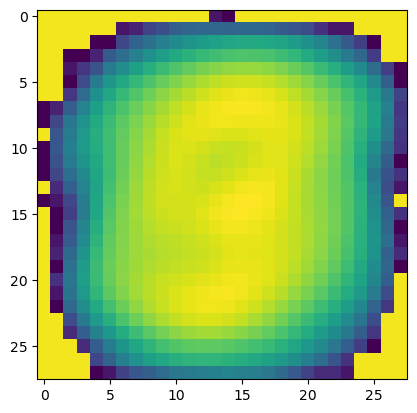

In [24]:

image = bias_visible.reshape(28,28)
plt.imshow(image)
plt.show()

In [34]:


class Trainable():

    def __init__(self, num_row, num_column) -> None:
        self.weights = numpy_rng.normal(loc=0.0, scale=0.01, size=(num_row, num_column))
        self.prev_gw = np.zeros(self.weights.shape)
        self.prev_gbv = np.zeros(num_row)
        self.prev_gbh = np.zeros(num_column)
        self.t_iter = 0
        self.prev_p_h0 = np.zeros(num_column)



    def compile(self, batch_size, epochs, learning_rate, weight_cost, momentum):
        self.batch_size = batch_size
        self.epoch_size = epochs
        self.learning_rate = learning_rate
        self.weight_cost = weight_cost
        self.momentum = momentum

        return self

    def calculate_gradient(self, data):
        pass

    def predict(self, data):
        pass

    def update_weights(self, gradient):
        self.weights += gradient['gw']


The weights are initialized by drawing random samples from a normal distribution with $μ(x) = 0$ and $σ(x) = 0.01$

## The Implementation of the Restricted Boltzmann Machine

I decided, as experiment, to initialize the hidden bias with random samples drawn from a uniform random variable with low equal to -0.00001 and high as  0.00001.The paper suggested setting this parameter to 0. I opted for a small non-zero value instead, to investigate its influence on the model's behavior.

P.s The model exhibits improved performance when the hidden bias is set to zero.

In [35]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def bernoulli(p):
    return (numpy_rng.rand(*p.shape) < p).astype(np.float32)





class RBM(Trainable):
    def __init__(self, num_visible_units, num_hidden_units, biasV=None) -> None:
        self.num_hidden_units = num_hidden_units
        self.num_visible_units = num_visible_units


        self.biasH = np.zeros(self.num_hidden_units) #np.random.uniform(low=-0.00001, high=0.00001, size=(self.num_hidden_units, 1)).squeeze()
        self.biasV = biasV if biasV is not None else np.random.uniform(low=-1, high=1, size=(self.num_visible_units, 1)).squeeze()
        super().__init__(self.num_visible_units, self.num_hidden_units)



    @property
    def num_visible(self):
        return self.num_visible_units

    @property
    def num_hidden(self):
        return self.num_hidden_units

    def sample_hidden(self, visible_units):
        activation = (visible_units @ self.weights) + self.biasH
        h1_mean = sigmoid(activation)
        return h1_mean, bernoulli(h1_mean)

    def sample_visible(self, hidden_units):
        activation = (hidden_units @ self.weights.T) + self.biasV
        v1_mean = sigmoid(activation)
        return v1_mean, bernoulli(v1_mean)

    def get_energy(self, visible_units):
        hidden_units = self.sample_hidden(visible_units)
        s = visible_units.T @ self.weights @ hidden_units[1]
        return ( - s - self.biasH.T @ hidden_units[1]- self.biasV.T @ visible_units).sum()

    def gibbs_sampling(self, visible_units):
        visible_units = np.zeros((1, self.num_visible_units)), visible_units
        while True:
            hidden_units = self.sample_hidden(visible_units[1])
            yield visible_units, hidden_units
            visible_units = self.sample_visible(hidden_units[1])

    def update_weights(self, gradient):
        return super().update_weights(gradient)

    # Remember v1, h1 are tuples of (probability, sampled)
    # Remember each value of key is a tuple of (v1, h1)
    def predict_h1(self, data):
        print(data.flatten().shape)
        if data.ndim == 3:
            data = data.flatten()
            passes = self.gibbs_sampling(data)
            v0, h0 = next(passes)
            v1, h1 = next(passes)
            print(v1)
            return v1,h1
        else:
            data = data.reshape(data.shape[0], self.num_visible_units)
            predictions = {}
            for i, d in tqdm.tqdm(enumerate(data)):
                passes = self.gibbs_sampling(d)
                v0, h0 = next(passes)
                v1, h1 = next(passes)
                predictions.update({i: (v1, h0)})
            return predictions

    def train(self, data):
        data = data.reshape(data.shape[0], self.num_visible_units).copy()
        total_size = data.shape[0]
        energy_error = []
        error = []
        for epoch in range(self.epoch_size):
            error.append([])
            energy_error.append([])
            print(f"Epoch {epoch+1} out of {self.epoch_size}")
            for i in tqdm.tqdm(range(0, len(data), self.batch_size)):
                if i + self.batch_size > total_size:
                    self.batch_size = total_size - i
                batched_data = data[i:i+self.batch_size]
                gradient = self.calculate_gradient(batched_data)
                self.update_weights(gradient)
                self.biasV += gradient['gbv']
                self.biasH += gradient['gbh']
                energy_error[epoch].append(gradient['energy_error'])
                error[epoch].append(gradient['error'])

                del gradient
            plt.hist(self.weights.flatten(), bins='auto')
            plt.title("Histogram of Weights -- Epoch {}".format(epoch+1))
            plt.show()
            plt.hist(self.biasV, bins='auto')
            plt.title("Histogram of Visible Bias -- Epoch {}".format(epoch+1))
            plt.show()
            plt.hist(self.biasH, bins='auto')
            plt.title("Histogram of Hidden Bias -- Epoch {}".format(epoch+1))
            plt.show()

            self.prev_p_h0 /= data.shape[0]
            prob_img = self.prev_p_h0.reshape(24, 24)
            plt.imshow(prob_img, cmap='gray')
            plt.title("The Average Probability of Hidden Units of the batch")
            plt.show()
            self.prev_p_h0 = np.zeros(self.num_hidden_units)



            if self.momentum < 0.9 and epoch == self.epoch_size // 3:
                self.momentum += (0.9 - self.momentum) / (self.epoch_size / 2)

            print(f"Epoch Mean Square Error {np.array(np.mean(error[epoch]))} ---- Energy Error {np.array(energy_error[epoch]).mean()}")
        return self.weights, self.biasV, self.biasH, energy_error, error

    def calculate_gradient(self, batched_data):

        np.random.shuffle(batched_data)

        updates = {"gw": np.zeros(self.weights.shape), "gbv": np.zeros(self.biasV.shape), "gbh": np.zeros(self.biasH.shape), "energy_error": 0, "error": 0}


        def calc_deltas(data, updates):
            passes = self.gibbs_sampling(data)
            v0, h0 = next(passes) # v0[0] is the 0 vector of the visible units, v0[1] is the actual data
            v1, h1 = next(passes) # v1[0] is the probability    , v1[1] is the sampled visible units
            updates['gw'] += (np.outer(v0[1].T, h0[0]) - np.outer(v1[1].T, h1[0]))

            updates['gbv'] += (np.sum(v0[1]) - np.sum(v1[0]))
            updates['gbh'] += (np.sum(h0[1]) - np.sum(h1[0]))

            updates['error'] += np.mean((v0[1] - v1[1])**2)
            self.prev_p_h0 += h0[0]
            updates['energy_error'] += (self.get_energy(v0[1]) - self.get_energy(v1[1])).mean()
            return data
        np.apply_along_axis(calc_deltas, 1, batched_data, updates)
        updates['gw'] /= self.batch_size
        updates['gbv'] /= self.batch_size
        updates['gbh'] /= self.batch_size
        updates['gw'] = self.momentum * self.prev_gw + (1. - self.momentum) * updates['gw']
        updates['gbv'] = self.momentum * self.prev_gbv + (1. - self.momentum) * updates['gbv']
        updates['gbh'] = self.momentum * self.prev_gbh + (1. - self.momentum) * updates['gbh']
        self.prev_gbv = updates['gbv']
        self.prev_gbh = updates['gbh']
        self.prev_gw = updates['gw']
        updates['gw'] = self.learning_rate * (updates['gw'] - self.weight_cost * self.weights)
        updates['gbv'] = self.learning_rate * updates['gbv']
        updates['gbh'] = self.learning_rate * updates['gbh']
        updates["energy_error"] /= self.batch_size
        updates["error"] /= self.batch_size

        self.prev_p_h0 /= self.batch_size
        return updates



rbm = RBM(len_v_vec, 576, bias_visible)

The training process updates the parameters in batches, leveraging momentum, L2 regularization, and a learning rate to optimize the model. For each piece of data, it computes the positive phase (wake) and the negative phase (dream) and accumulates the difference. Same for the visible and hidden biases. This sum is then divided by the batch size to obtain the average gradient. To improve clarity, I've chosen to calculate the update for the weight parameters as follows: $v_i = \operatorname{momentum} \cdot v_{i-1} + (1 - \operatorname{momentum}) \cdot v_i$.

## Train the model

Starts with 0.5 momentum and then increases, the maximum is 0.9. I experimented with various learning rates and weight decay values (e.g., learning rate = 0.0001, weight decay = 0.00001). However, the model's accuracy only reached 0.9. Among all the values I explored, the configuration below yielded the best results.

Epoch 1 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.04it/s]


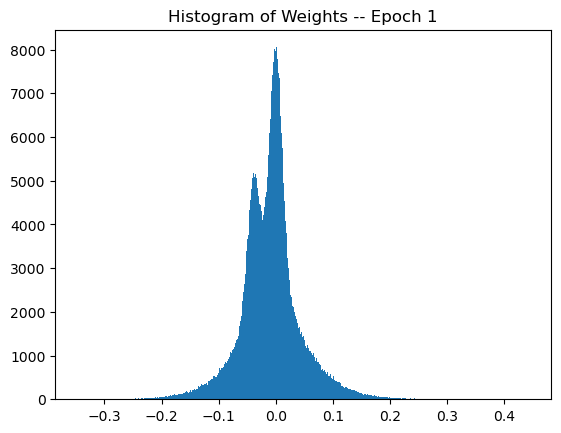

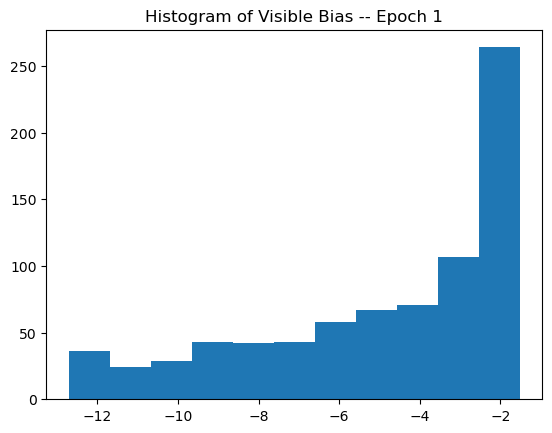

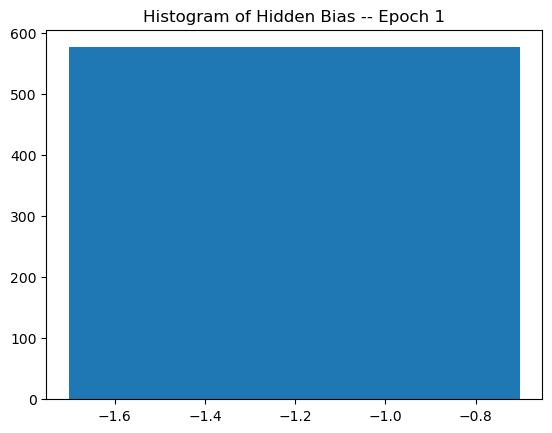

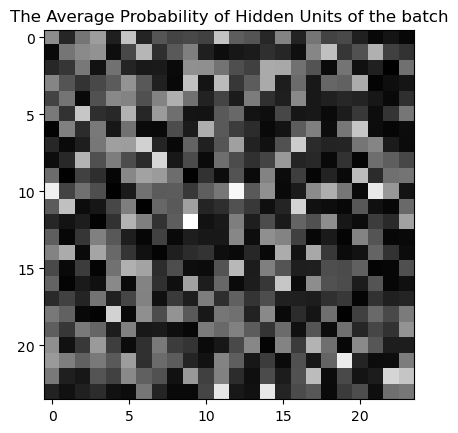

Epoch Mean Square Error 0.11239538444861005 ---- Energy Error -5.308355603220259
Epoch 2 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:00<00:00, 10.38it/s]


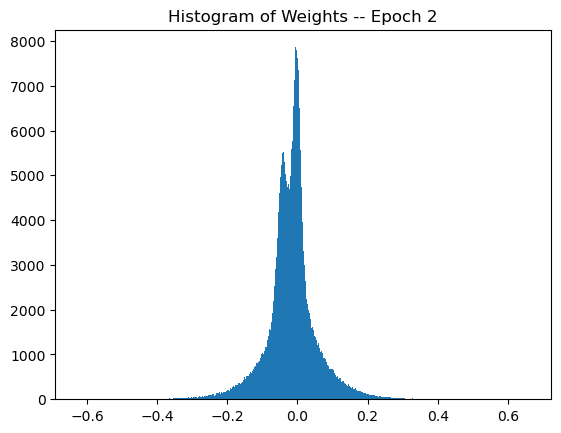

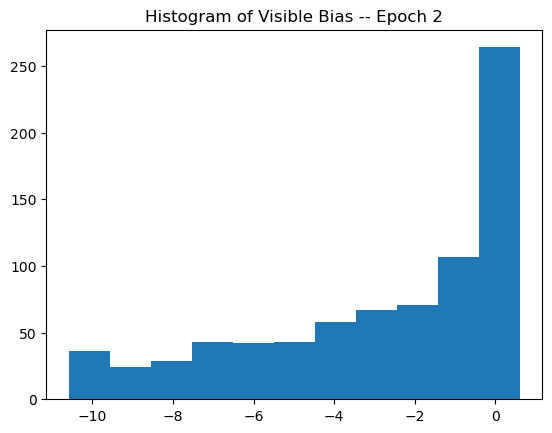

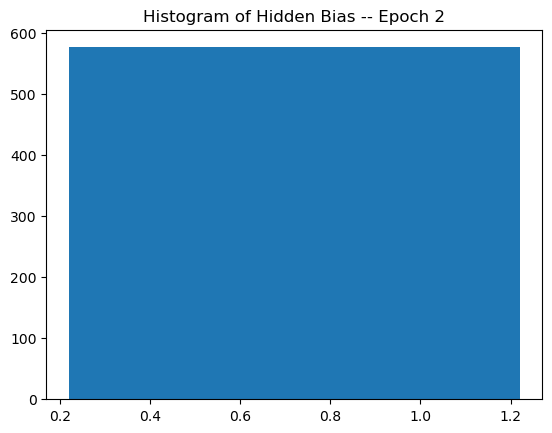

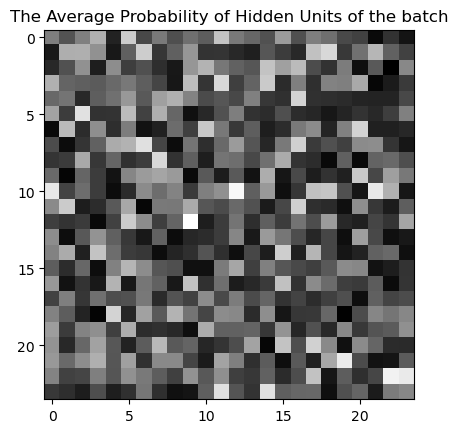

Epoch Mean Square Error 0.07432678561643698 ---- Energy Error -9.078331474736345
Epoch 3 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.75it/s]


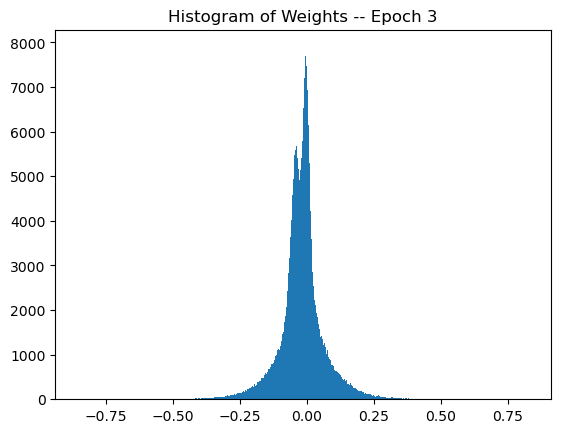

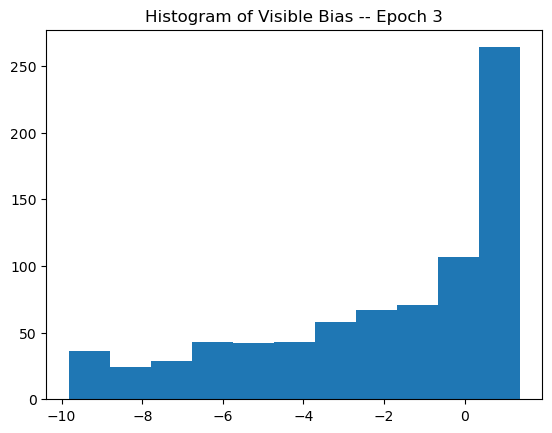

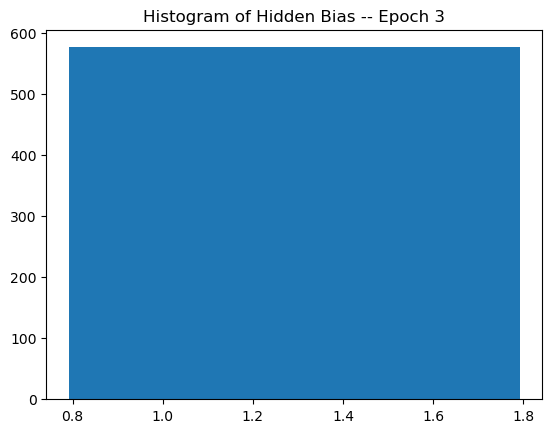

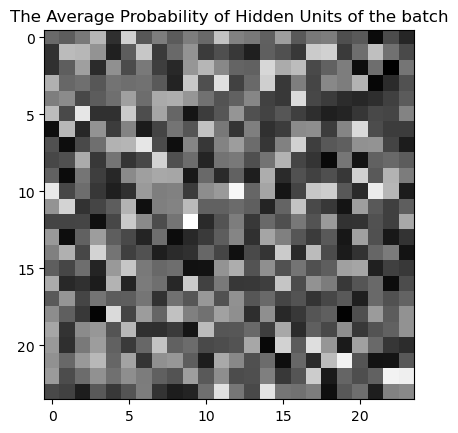

Epoch Mean Square Error 0.06285846082121134 ---- Energy Error -6.087591519351779
Epoch 4 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:02<00:00, 10.07it/s]


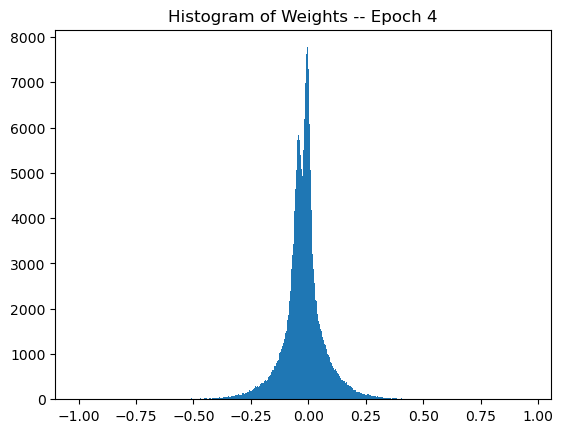

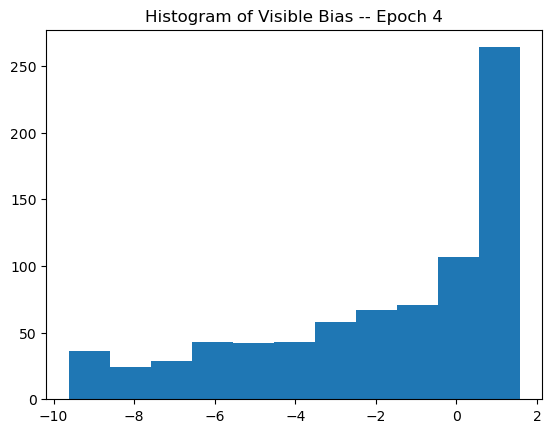

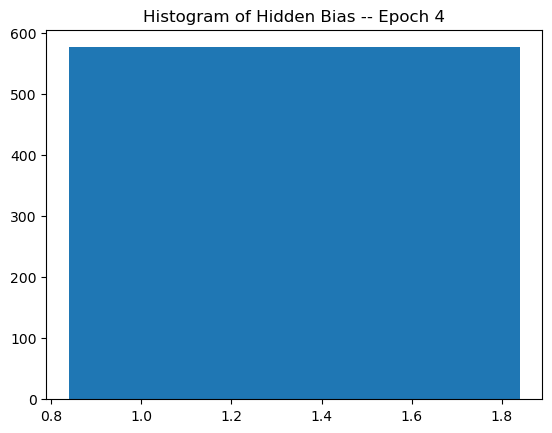

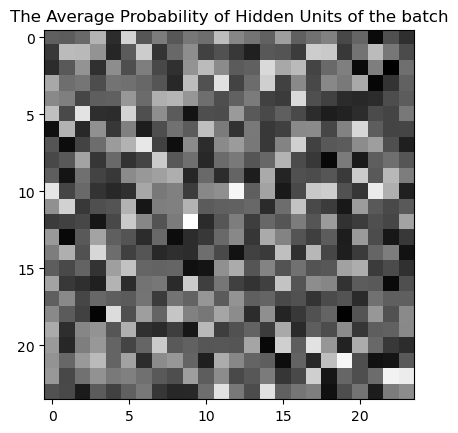

Epoch Mean Square Error 0.0576039753025708 ---- Energy Error -4.700649334344489
Epoch 5 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:00<00:00, 10.41it/s]


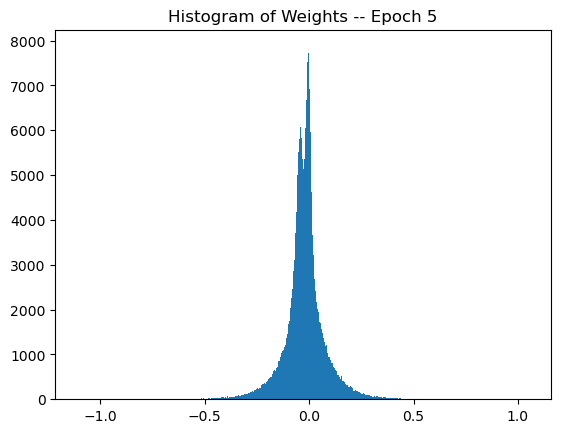

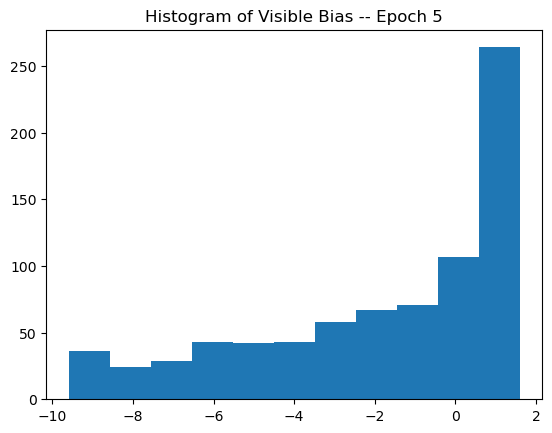

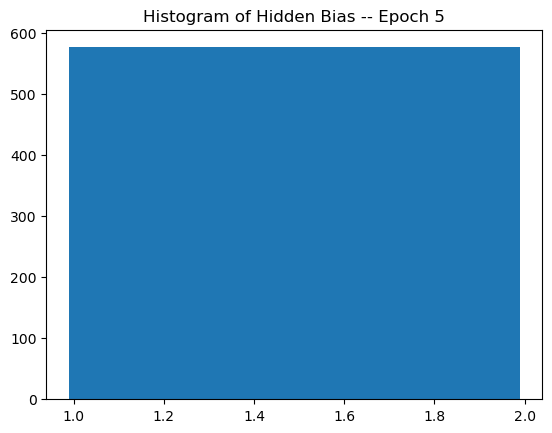

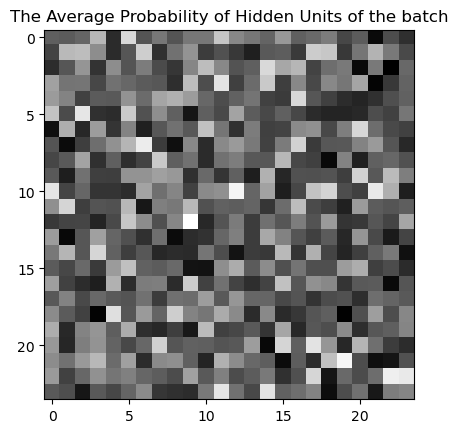

Epoch Mean Square Error 0.054445365633008384 ---- Energy Error -3.6773147611852153
Epoch 6 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:01<00:00, 10.15it/s]


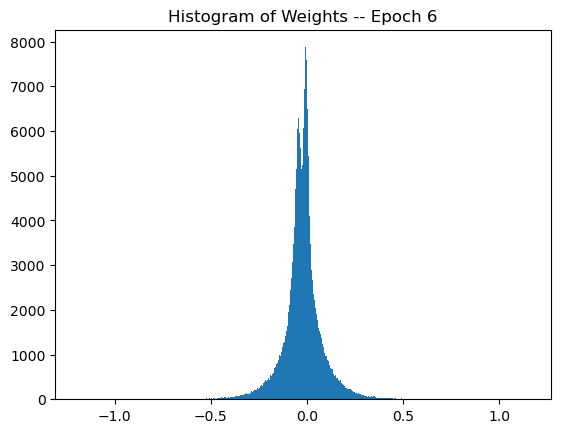

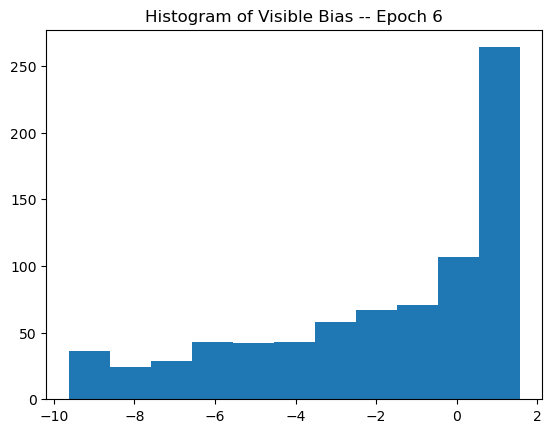

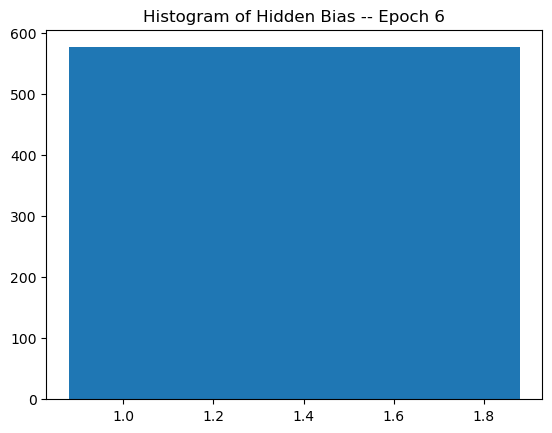

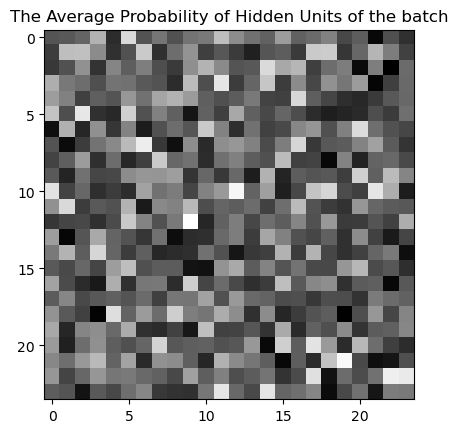

Epoch Mean Square Error 0.05228673470988094 ---- Energy Error -3.1953113209568693
Epoch 7 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:00<00:00, 10.35it/s]


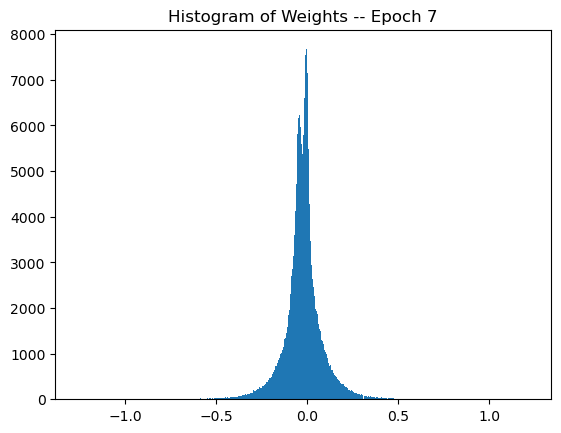

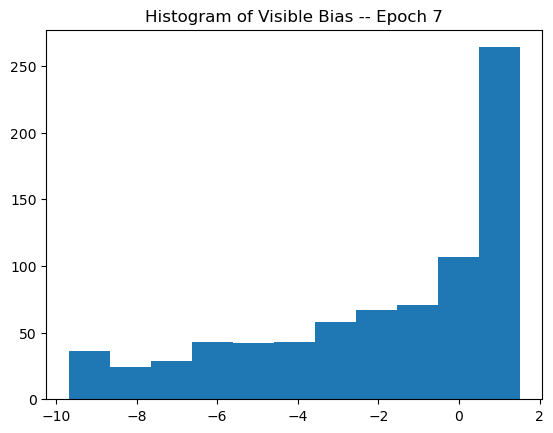

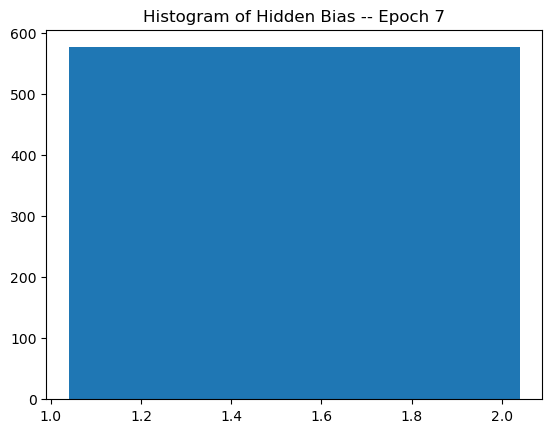

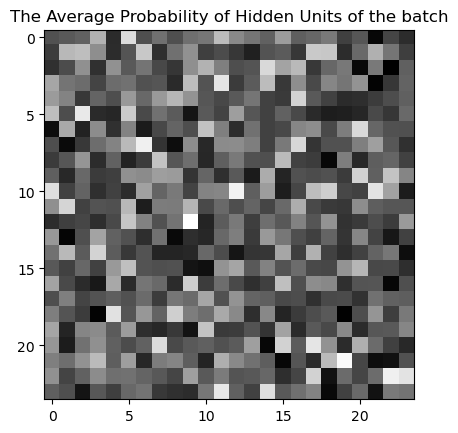

Epoch Mean Square Error 0.050583142017767146 ---- Energy Error -2.610941848664949
Epoch 8 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:01<00:00, 10.17it/s]


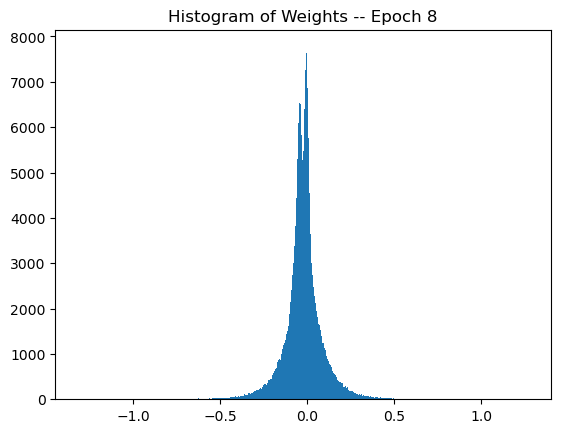

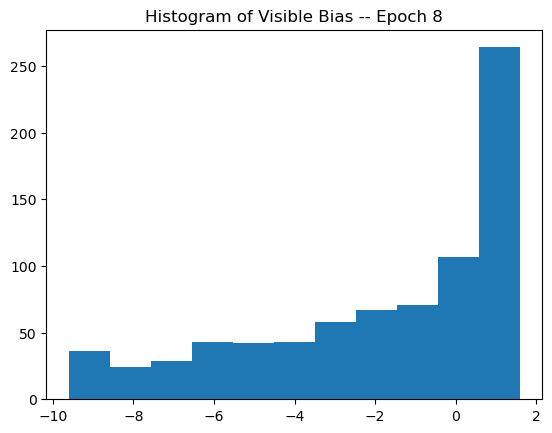

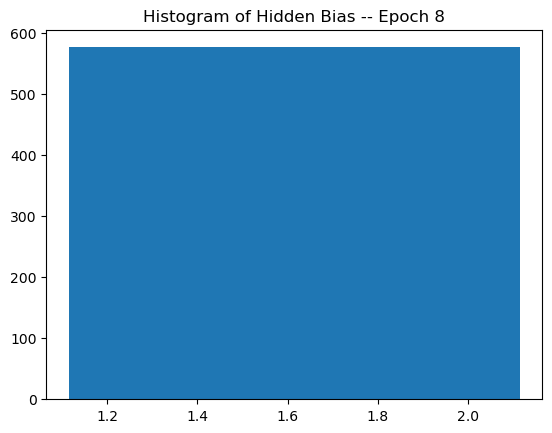

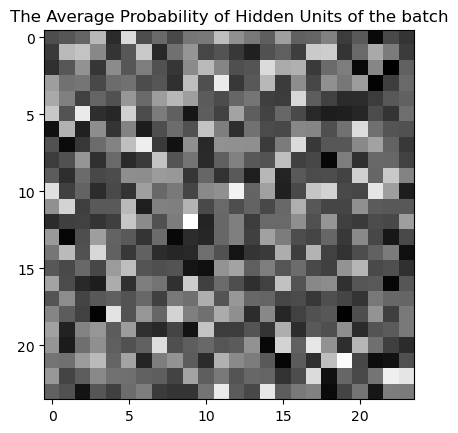

Epoch Mean Square Error 0.04929934100856384 ---- Energy Error -2.2839186822465716
Epoch 9 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:03<00:00,  9.77it/s]


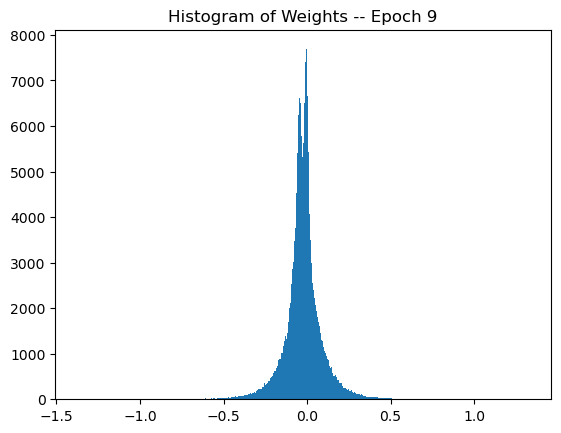

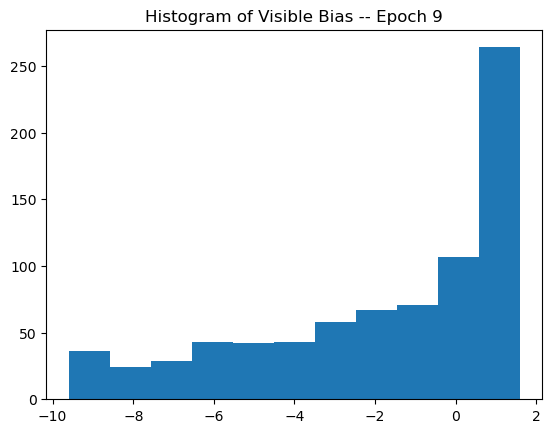

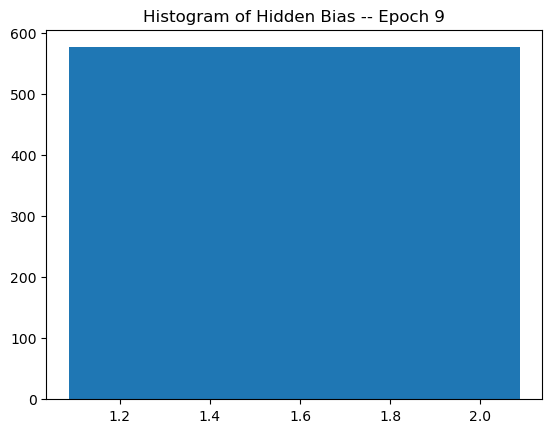

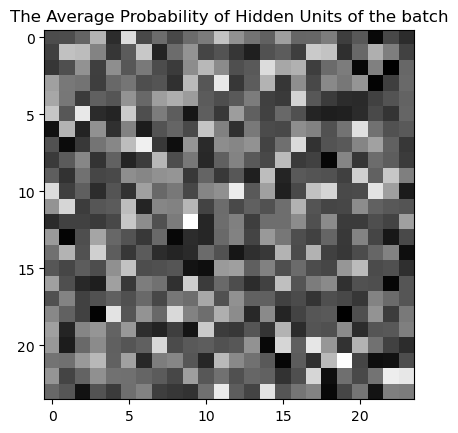

Epoch Mean Square Error 0.04814630106119439 ---- Energy Error -2.038757086158411
Epoch 10 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:59<00:00, 10.53it/s]


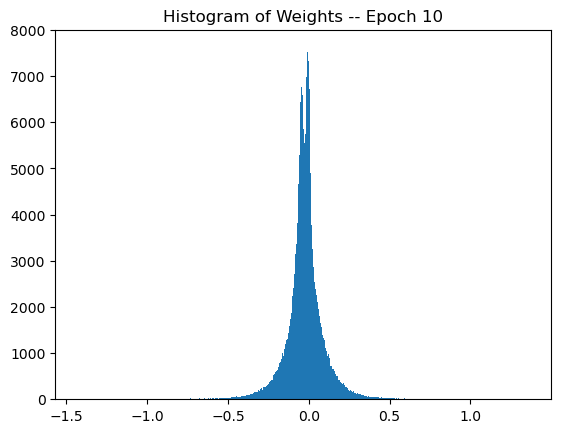

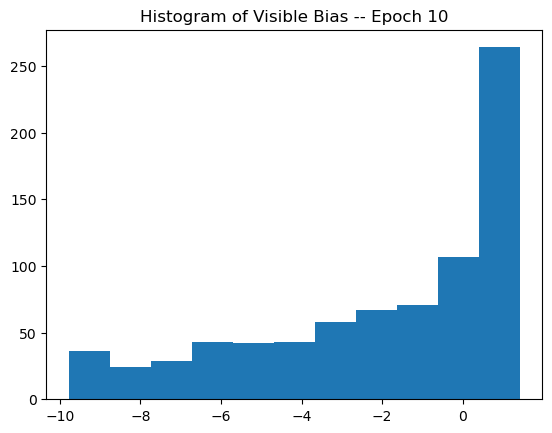

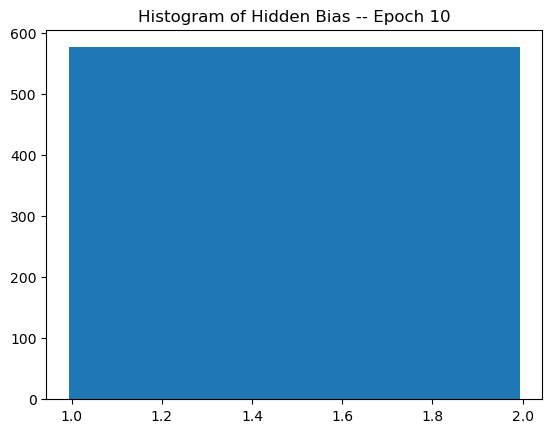

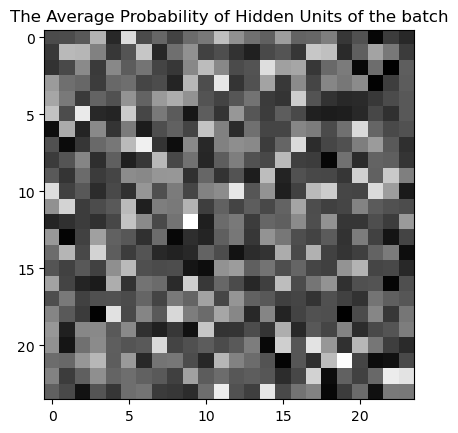

Epoch Mean Square Error 0.047226318073598665 ---- Energy Error -1.7776375617035378
Epoch 11 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:00<00:00, 10.34it/s]


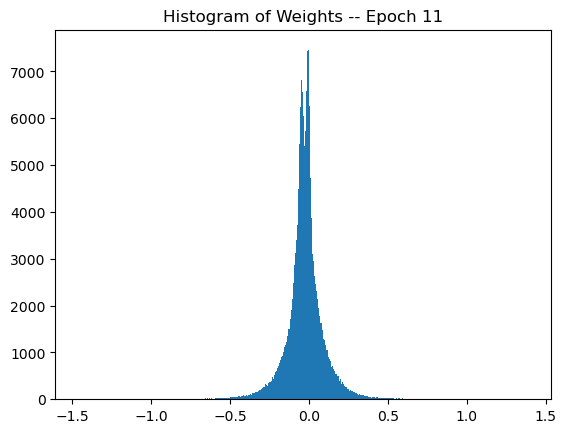

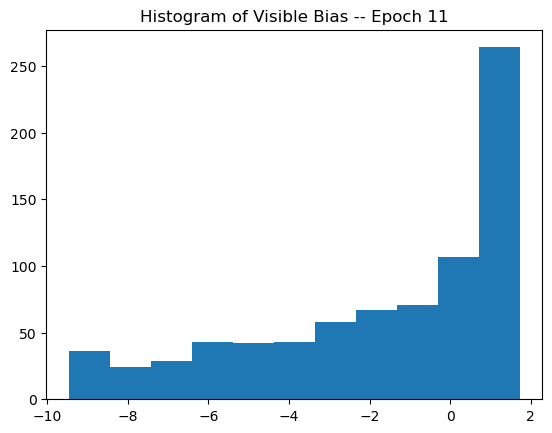

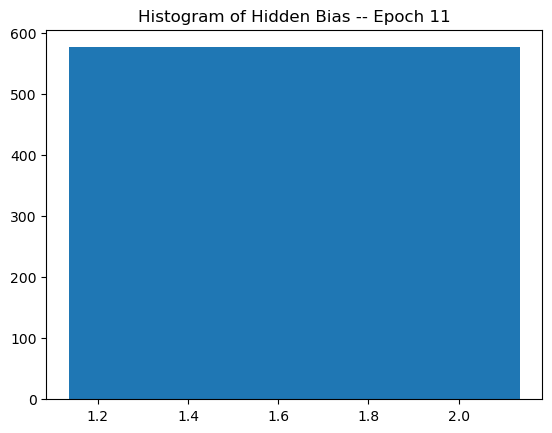

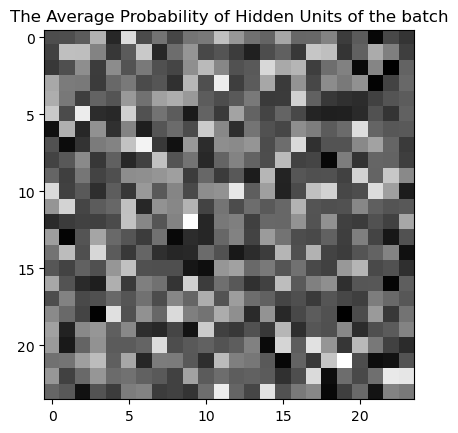

Epoch Mean Square Error 0.04644196433366742 ---- Energy Error -1.3819033527934084
Epoch 12 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.89it/s]


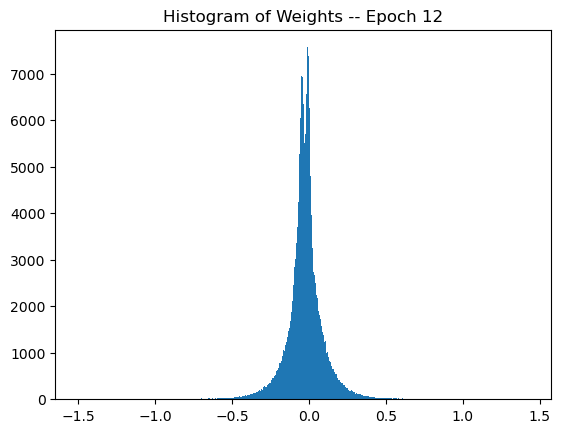

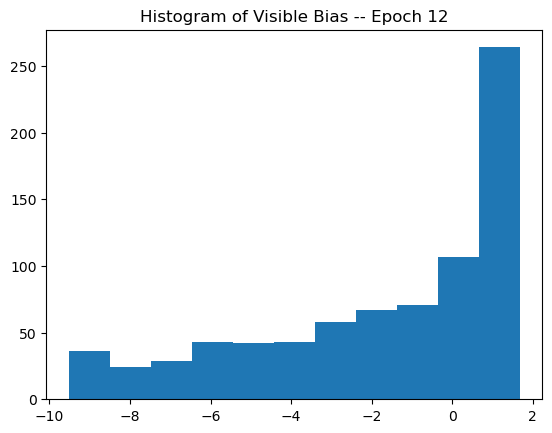

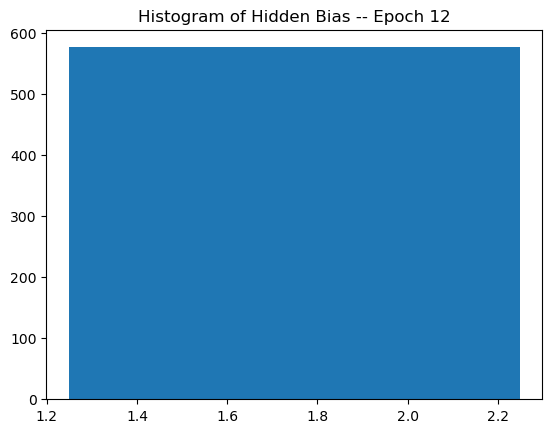

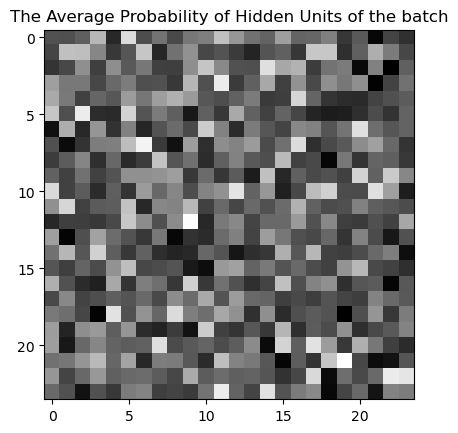

Epoch Mean Square Error 0.04583624580545196 ---- Energy Error -1.3084801981825582
Epoch 13 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.86it/s]


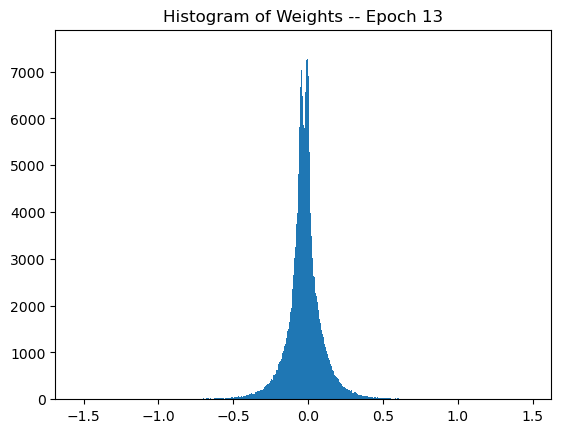

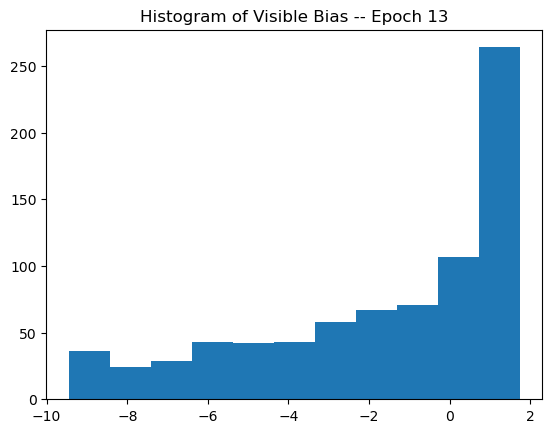

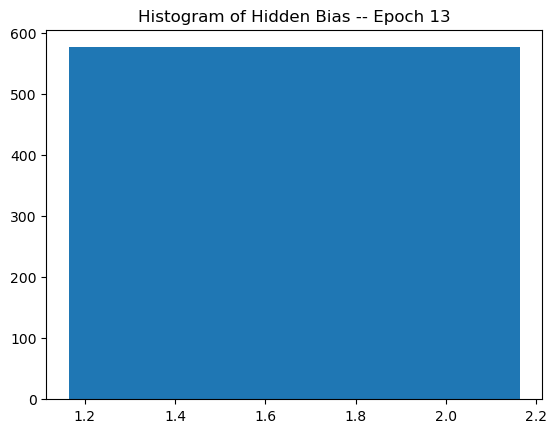

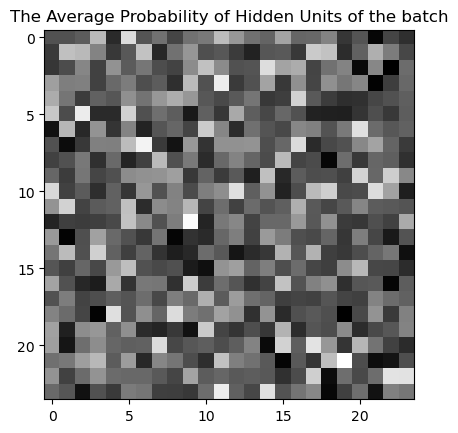

Epoch Mean Square Error 0.04531164970940057 ---- Energy Error -1.0713051802278046
Epoch 14 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:00<00:00, 10.30it/s]


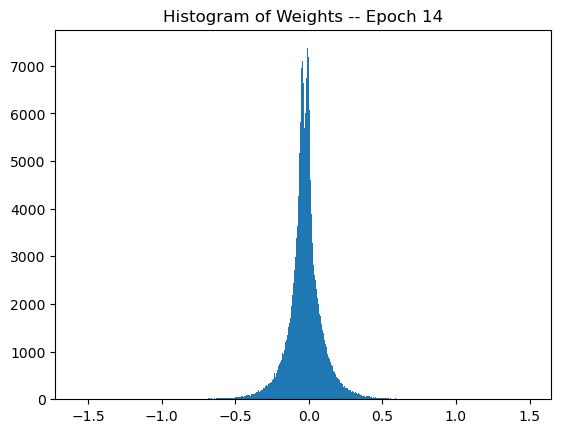

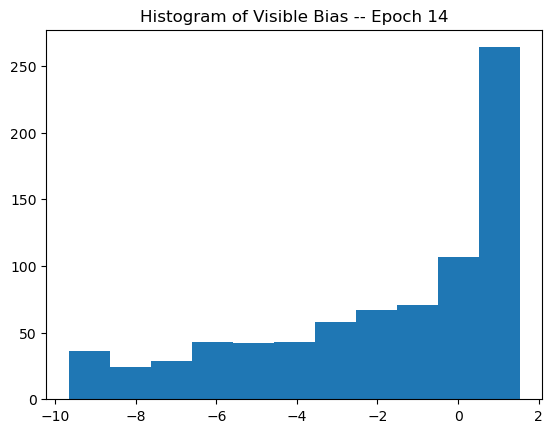

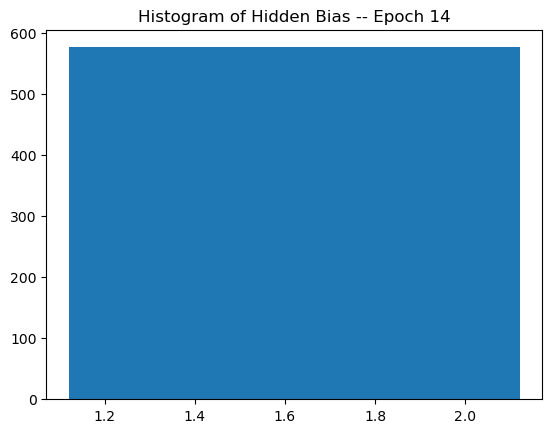

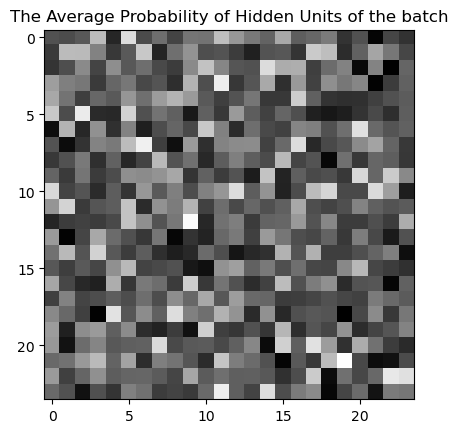

Epoch Mean Square Error 0.04481177726714717 ---- Energy Error -1.2138579501683662
Epoch 15 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.61it/s]


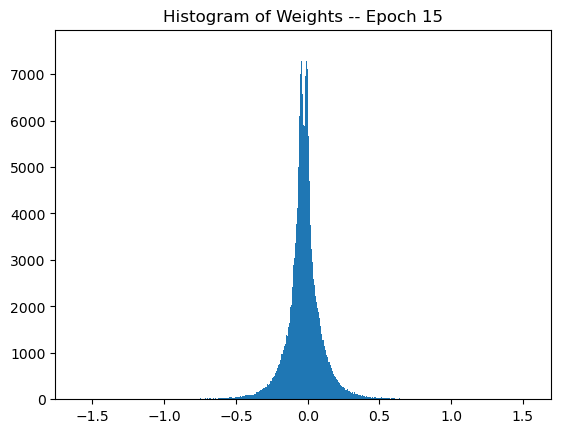

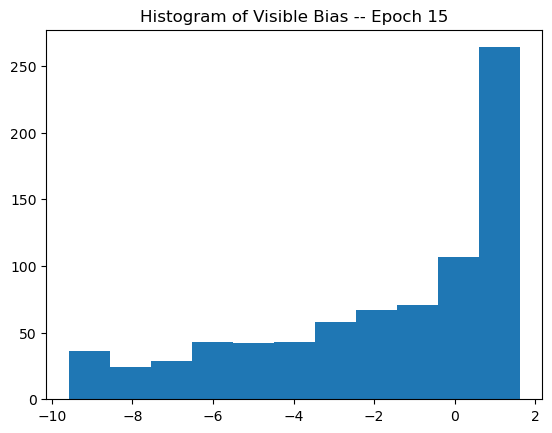

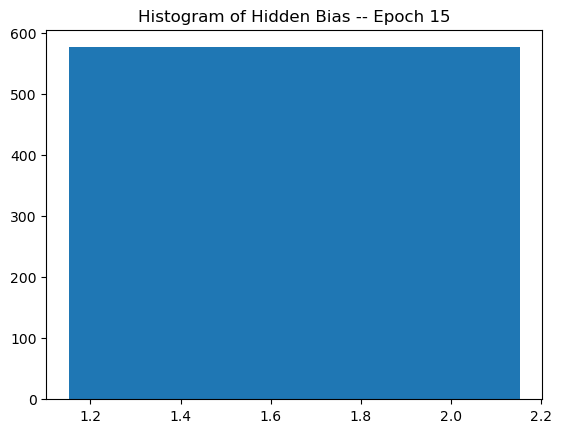

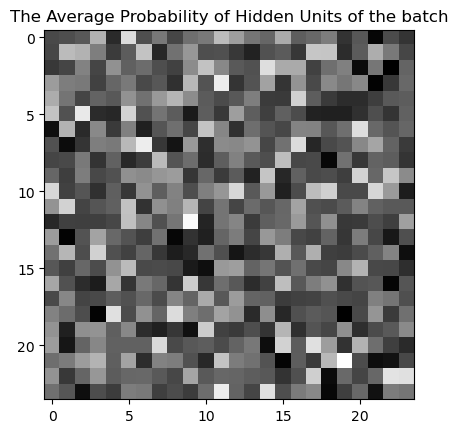

Epoch Mean Square Error 0.044307589351847615 ---- Energy Error -1.1310192493362565
Epoch 16 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.75it/s]


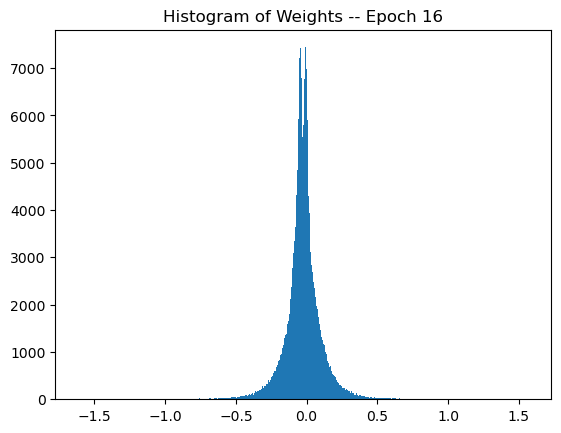

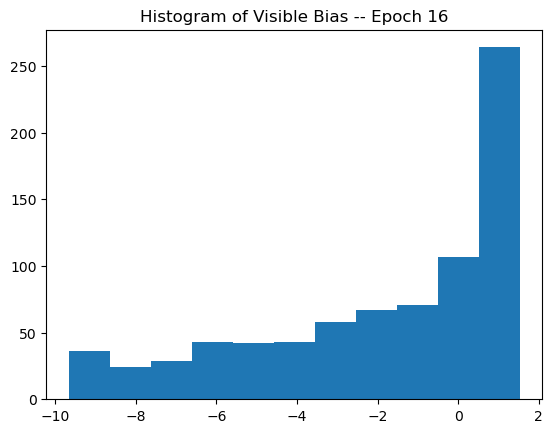

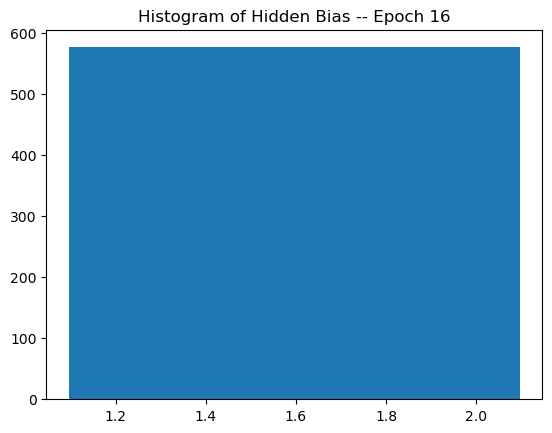

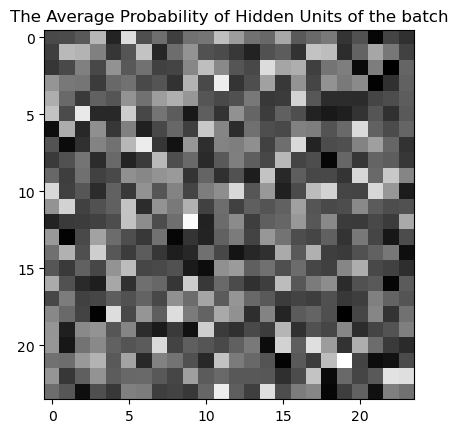

Epoch Mean Square Error 0.043886075750187346 ---- Energy Error -1.0049600863111043
Epoch 17 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.60it/s]


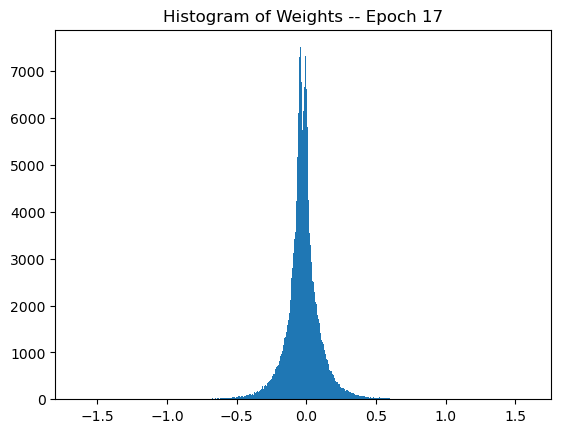

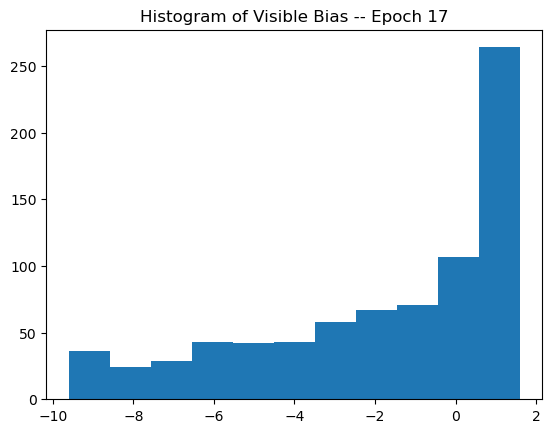

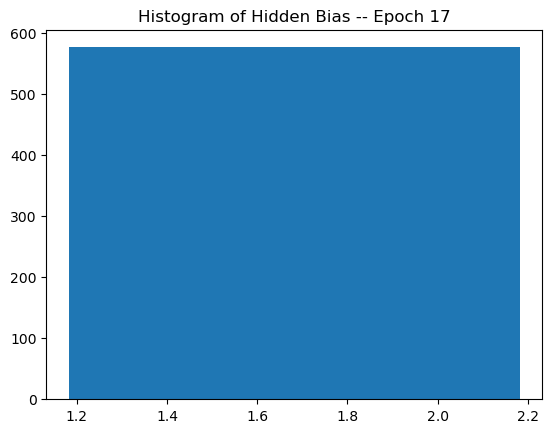

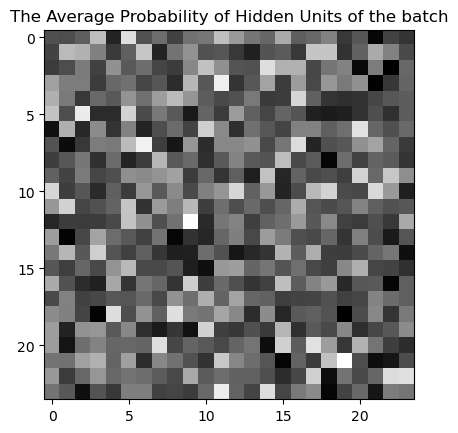

Epoch Mean Square Error 0.043519217754341664 ---- Energy Error -1.1411200487870752
Epoch 18 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.73it/s]


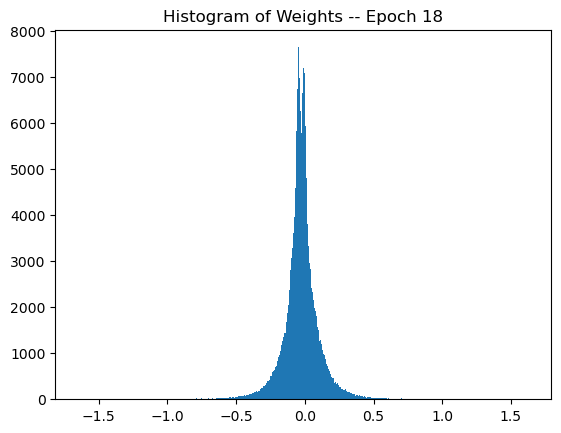

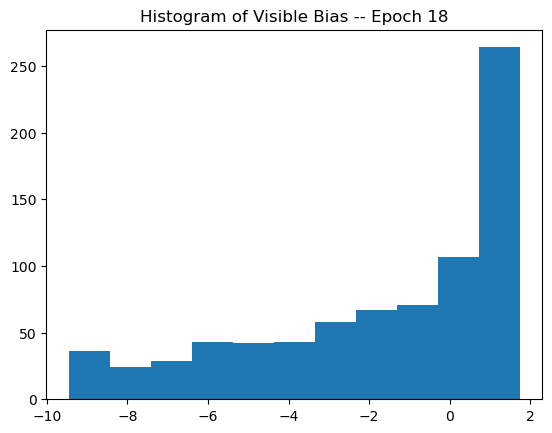

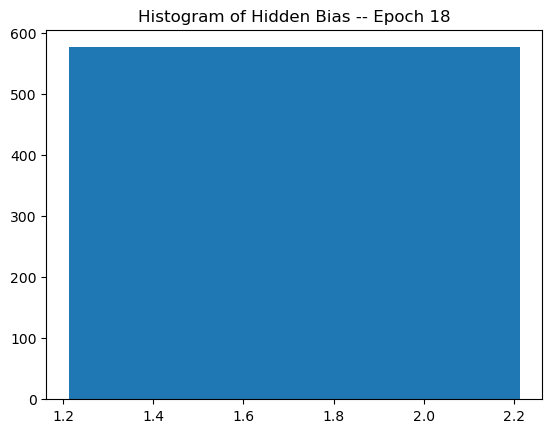

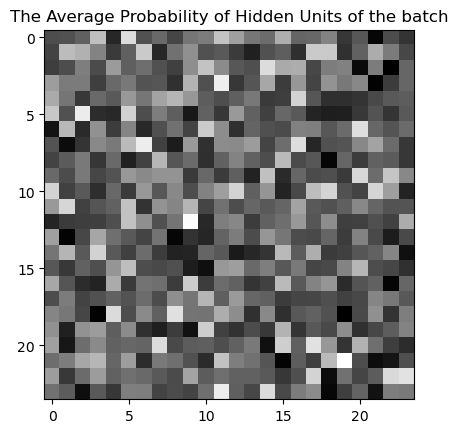

Epoch Mean Square Error 0.043080250927084125 ---- Energy Error -0.8853232406280444
Epoch 19 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.80it/s]


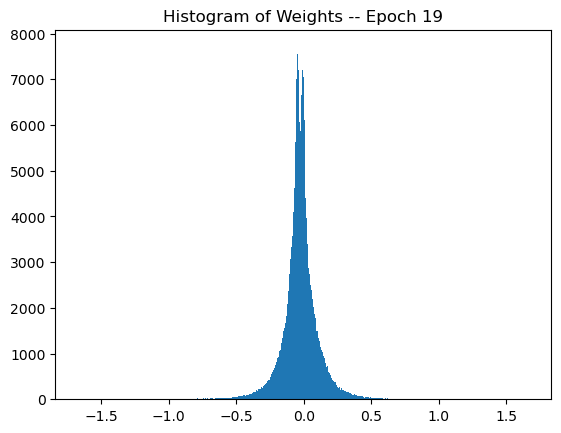

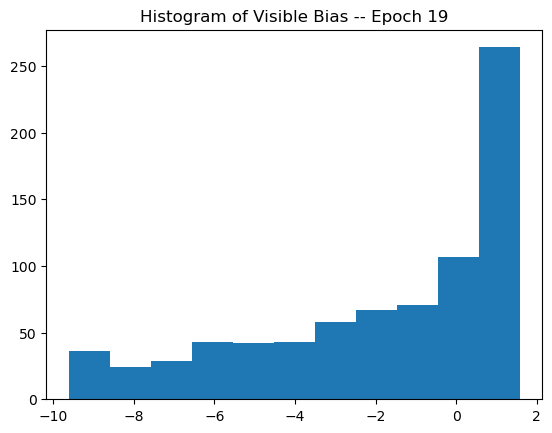

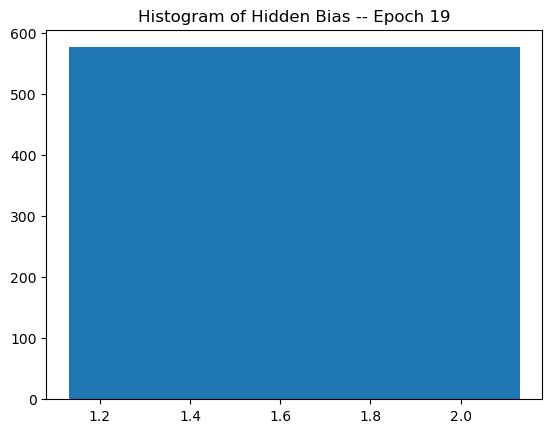

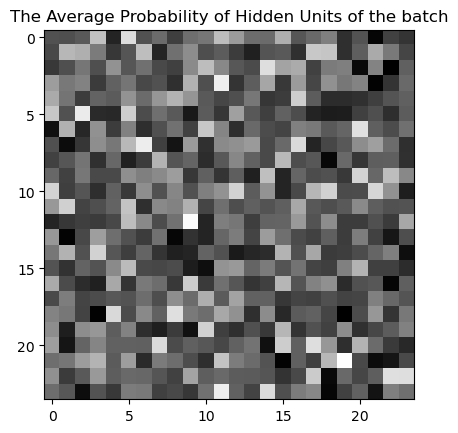

Epoch Mean Square Error 0.042792538333451376 ---- Energy Error -0.7932774963570584
Epoch 20 out of 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [01:01<00:00, 10.16it/s]


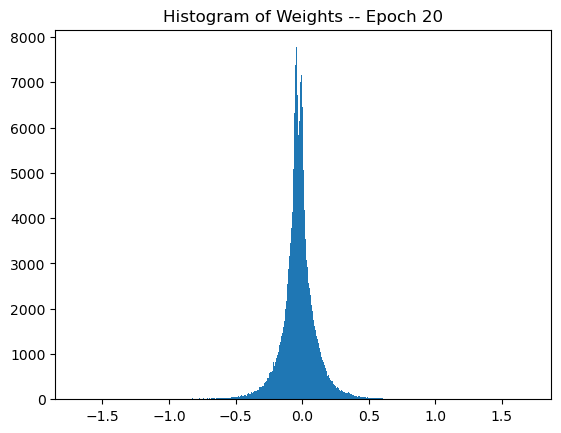

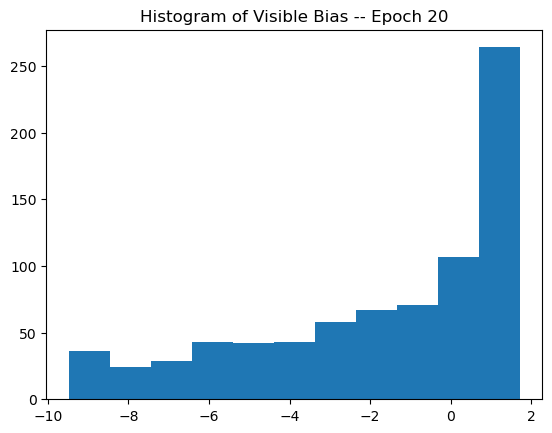

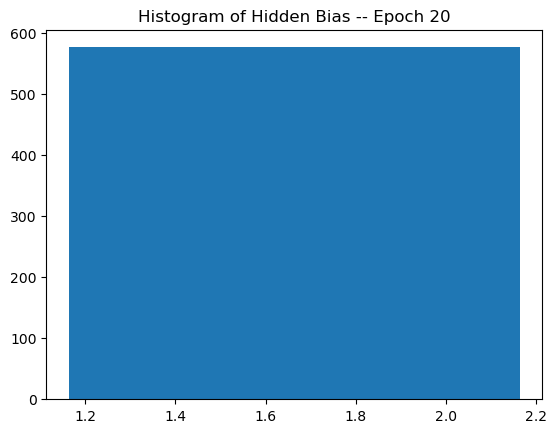

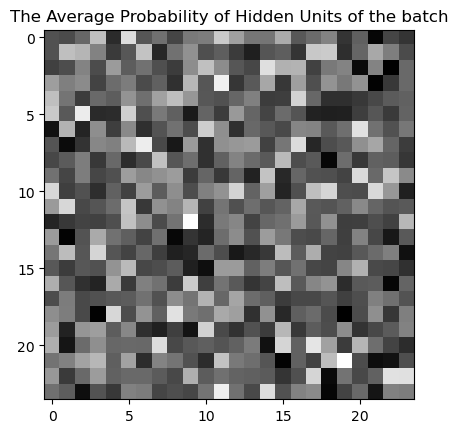

Epoch Mean Square Error 0.042490221156319605 ---- Energy Error -0.6743142539705248


In [36]:
conf = {
    "momentum": 0.5,
    "weight_cost": 0.00008,
    "learning_rate": 0.08,
    "epochs": 20,
    "batch_size": 128,
}

rbm.compile(**conf)
r = rbm.train(data)

During training, the model's weights exhibit a tendency to concentrate around 0 and progressively increase in magnitude with each epoch. Furthermore, excessively concentrated weights can lead to overfitting. To monitor the model's training progress, the paper suggests visualizing the hidden unit activation probabilities. Ideally, these activations should exhibit a random distribution, with no discernible patterns emerging. The visualization reveals significant positive bias for certain values in the visible layer. According to the referenced paper, this is a desirable characteristic.

(784,)


1it [00:00, 1921.35it/s]


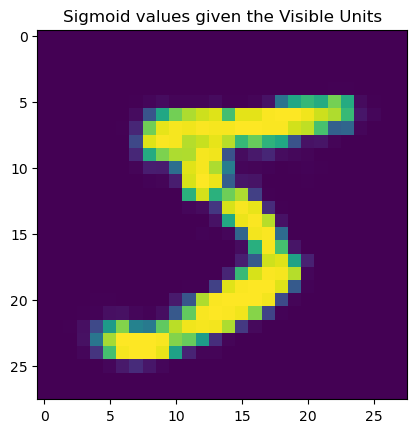

In [44]:
image = rbm.predict_h1(data[0].squeeze().reshape(1, len_v_vec))
image = image[0][0][0].reshape(28, 28)


plt.imshow(image)
plt.title("Sigmoid values given the Visible Units")
plt.show()

Without significant parallelization, training takes a long time. To expedite future use, let's save the current model to a local file for reuse.

In [52]:
from io import StringIO
import json
weights = rbm.weights
biasH = rbm.biasH
biasV = rbm.biasV

# from google.colab import drive
# from google.colab import data_table


# drive.mount('/content/drive')

def array_2_string(array):
    str_out = StringIO()
    np.savetxt(str_out, array)
    return str_out.getvalue()

rbm_dict = {"weights": array_2_string(weights), "biasH": array_2_string(biasH), "biasV": array_2_string(biasV)}
with open("/home/lesi-nedo/Desktop/master/second-semester/ISPR/ass/rbm_model.json", "w") as f:
    json.dump(rbm_dict, f, indent=4, sort_keys=True)
    f.flush()

In [ ]:
def string_2_array(string):
    str_in = StringIO(string)
    array_tmp = np.loadtxt(str_in)
    if len(array_tmp.shape) == 0:
        return np.array([array_tmp])
    return array_tmp

rbm_dict = {}

with open("rbm_model.json", "r") as f:
    model = json.load(f)
    rbm_dict = {"weights": string_2_array(model["weights"]), "biasH": string_2_array(model["biasH"]), "biasV": string_2_array(model["biasV"])}

# rbm = RBM(len_v_vec, 1024, bias_visible)
# rbm.weights = rbm_dict["weights"]
# rbm.biasH = rbm_dict["biasH"]
# rbm.biasV = rbm_dict["biasV"]

## Download the test dataset

In [53]:
test_url = "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
test_label_url = "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"

test_imgs_name_f = 'test_imgs.gz'
test_label_imgs_name_f = 'test_labels.gz'

path_test_imgs = check_or_download(test_url, test_imgs_name_f)
path_test_labels = check_or_download(test_label_url, test_label_imgs_name_f)

with gzip.open(path_test_imgs, 'rb') as test_imgs_f:
    test_imgs = test_imgs_f.read()

with gzip.open(path_test_labels, 'rb') as test_labels_f:
    test_labels = test_labels_f.read()


test_imgs.gz already exists
test_labels.gz already exists


This code cell compares the downloaded image to its binarized version.

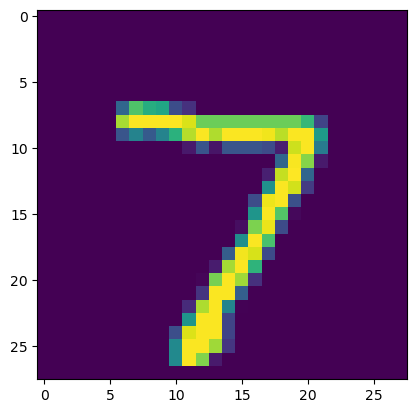

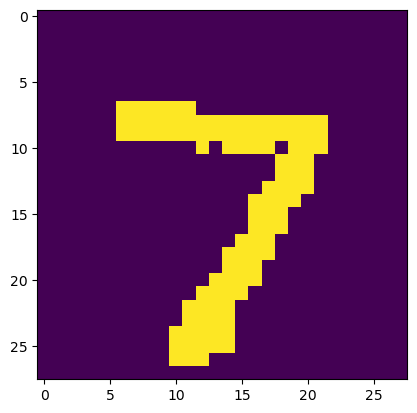

In [54]:
test_data = np.frombuffer(test_imgs, dtype=np.uint8, count=image_size*image_size*10000, offset=16).astype(np.float32)
test_data = test_data.reshape(10000, image_size, image_size, 1)
test_data_size = test_data.shape[0]
image = np.asarray(test_data[0]).squeeze()
plt.imshow(image)
plt.show()

test_data[test_data < threshold] = 0.0
test_data[test_data >= threshold] = 1.0

rand_d = numpy_rng.rand(*test_data.shape)


test_data = (rand_d < test_data).astype(np.float32)

image = np.asarray(test_data[0]).squeeze()
plt.imshow(image)
plt.show()


The ```predict_h1``` method returns a dictionary. The keys are numerical, ranging from 0 to the total number of test data points. Each key corresponds to a tuple containing two elements:      
* v1: This is another tuple containing the sigmoid activations for the visible layer and the reconstructed images.     
* h0: This tuple includes the sigmoid activations and the activated hidden layer neurons.

(7840000,)


10000it [00:01, 6791.85it/s]


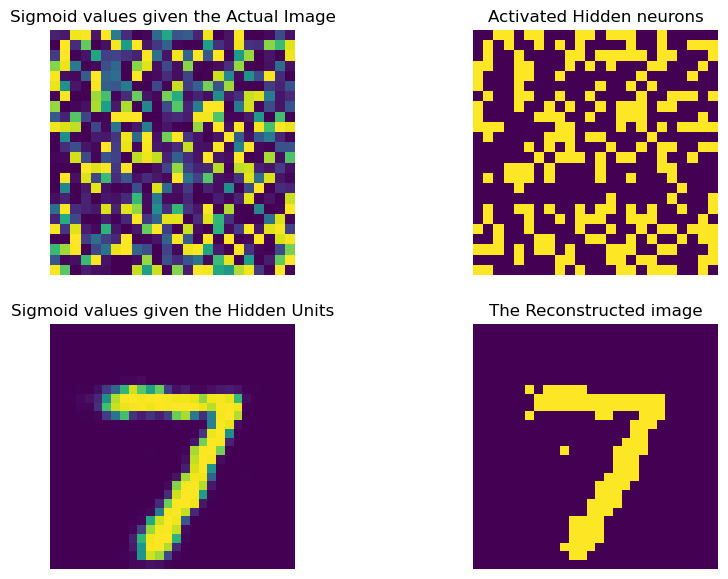

In [56]:
pred_test = rbm.predict_h1(test_data)

fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 2

image1 = pred_test[0][0][0].reshape(28, 28)
image2 = pred_test[0][0][1].reshape(28, 28)
image3 = pred_test[0][1][0].reshape(24, 24)
image4 = pred_test[0][1][1].reshape(24, 24)

fig.add_subplot(rows, columns, 1)

plt.imshow(image3)
plt.axis('off')
plt.title("Sigmoid values given the Actual Image")

fig.add_subplot(rows, columns, 2)

plt.imshow(image4)
plt.axis('off')
plt.title("Activated Hidden neurons")

fig.add_subplot(rows, columns, 3)

plt.imshow(image1)
plt.axis('off')
plt.title("Sigmoid values given the Hidden Units")

fig.add_subplot(rows, columns, 4)

plt.imshow(image1)
plt.axis('off')
plt.title("The Reconstructed image")



image = pred_test[0][0][1].reshape(28, 28)
plt.imshow(image)
plt.show()

In [57]:
import seaborn as sns
import statistics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [62]:
test_data_labels = np.frombuffer(test_labels, dtype=np.uint8, count=test_data_size, offset=8)
test_data_h1 = np.zeros((test_data_size, rbm.num_hidden_units))


for key, value in pred_test.items():
    test_data_h1[key] = value[1][0]

X_train, X_test, y_train, y_test = train_test_split(test_data_h1, test_data_labels, test_size=0.33, random_state=42)


## Data Plotting

Let's leverage compelling visualizations to explore which classification algorithm might reign supreme

<Axes: ylabel='Count'>

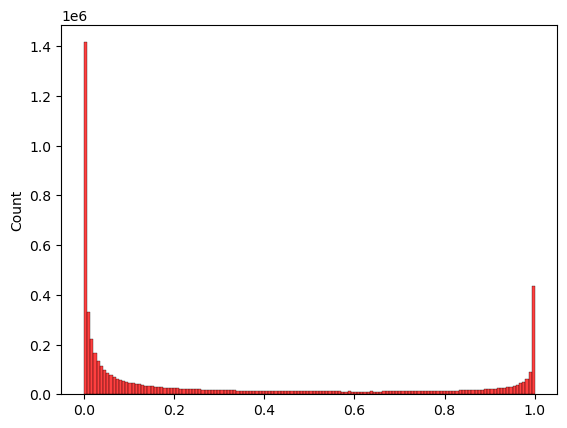

In [110]:
sns.histplot(test_data_h1.flatten(), label="All hidden states",  color="r")

The data appears to deviate from a normal distribution, which leads me to suspect that classification algorithms assuming normality might not perform well.

In [105]:
mean_test_data_h1 = np.apply_along_axis(np.mean, 1, test_data_h1)

<Axes: ylabel='Count'>

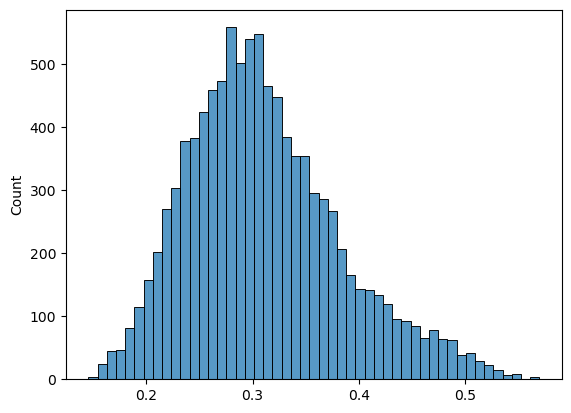

In [111]:
sns.histplot(mean_test_data_h1, label="The mean of each vector")

While the data itself may not be normally distributed, the means of the vectors seem to be

<Axes: ylabel='Density'>

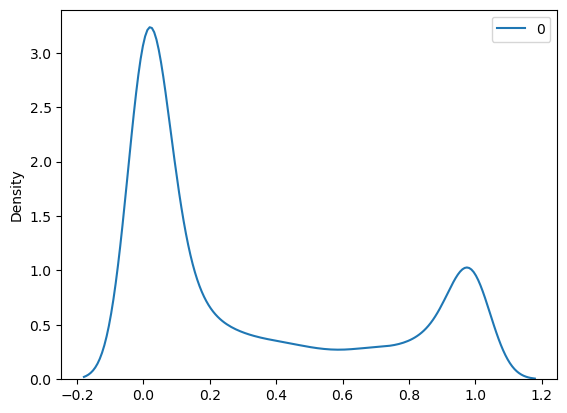

In [144]:
sns.kdeplot(np.apply_along_axis(np.random.choice, 1, test_data_h1, size=1))

To explore the data further, I randomly sampled a value from each vector and plotted the distribution. The results are not particularly encouraging.

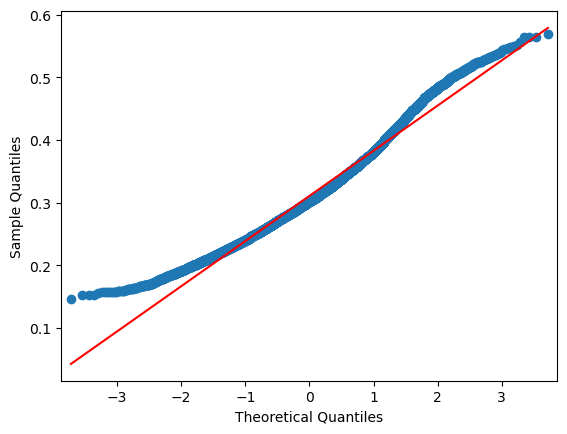

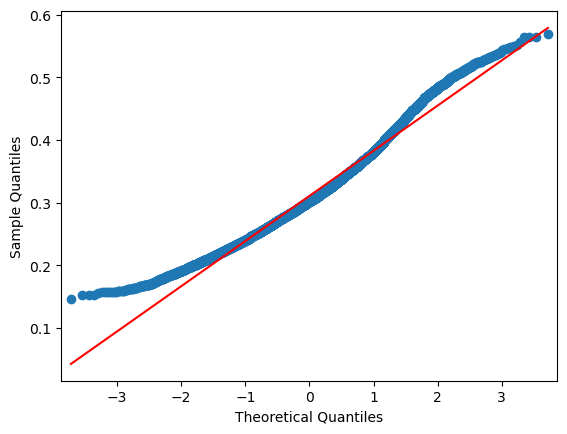

In [108]:
from statsmodels.graphics.gofplots import qqplot


qqplot(mean_test_data_h1, line='s')

Finally, I visualized the data using a Q-Q plot. This plot shows that the means of the vectors also deviate from a normal distribution.

## Classification

While I wasn't previously well-versed in AdaBoostClassifier, the clear graphical representation on scikit-learn's website piqued my interest, prompting me to experiment with it for this task.

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=400, algorithm="SAMME", random_state=89377)

nb = clf.fit(X_train, y_train)

While AdaBoostClassifier showed some improvement in accuracy with more iterations, this approach risks overfitting according to [this](https://www.datacamp.com/tutorial/adaboost-classifier-python). Given its slower performance compared to other algorithms, it might be best to explore alternative models for better efficiency and generalizability.

In [148]:
nb.score(X_test, y_test)

0.8212121212121212

<Axes: >

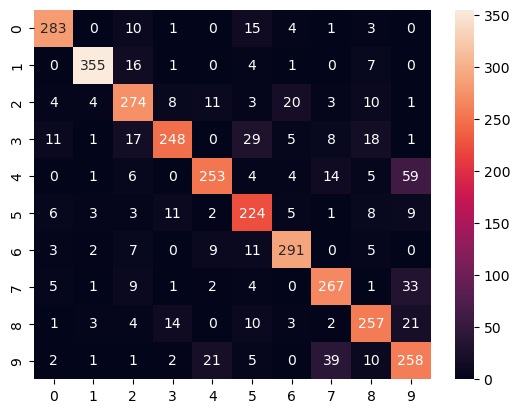

In [150]:
sns.heatmap(confusion_matrix(y_test, nb.predict(X_test)), annot=True, fmt='d')

While I wasn't previously familiar with this algorithm either, I opted to use it because I believed it could potentially learn the underlying data distribution.

In [215]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=450, random_state=89377, activation="relu", alpha=0.0008, learning_rate="constant", learning_rate_init=0.008, max_iter=600)

nb1 = clf.fit(X_train, y_train)


Hyperparameter tuning improved its performance, suggesting that the model has strong potential. However, I believe even better results could be achieved with a larger dataset. To explore simpler models, I'll move on to the next algorithm.

In [217]:
nb1.score(X_test, y_test)

0.9642424242424242

<Axes: >

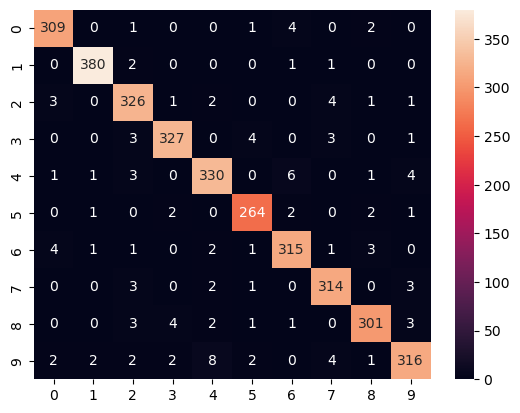

In [219]:
sns.heatmap(confusion_matrix(y_test, nb1.predict(X_test)), annot=True, fmt='d')

0.9436363636363636


<Axes: >

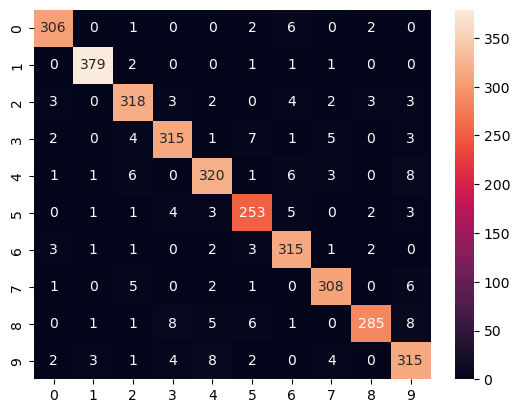

In [238]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=89377, solver='saga', penalty="l2", max_iter=400).fit(X_train, y_train)

print(clf.score(X_test, y_test))

sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt='d')

While Logistic Regression performed well, but other algorithms could achieve even better results.

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel="rbf",   C=6, random_state=89377))
clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=6, gamma='auto', random_state=89377))])

The high dimensionality of our data seems to be a good fit for the SVC algorithm, which explains its strong performance. This is a promising candidate!

In [274]:
clf.score(X_test, y_test)

0.9678787878787879

<Axes: >

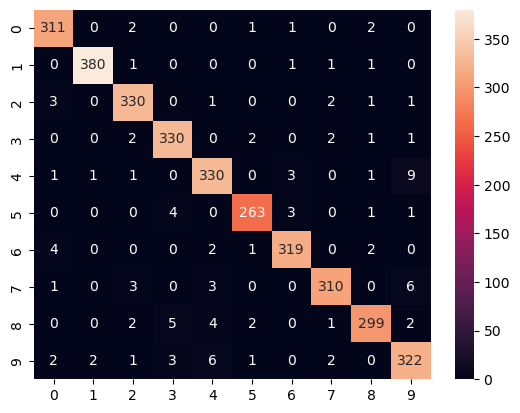

In [264]:
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt='d')

Just for fun, let's see what Gaussian Naive Bayes can do with this data.

In [266]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)

GaussianNB()

#### Meh

In [267]:
clf.score(X_test, y_test)

0.8815151515151515

<Axes: >

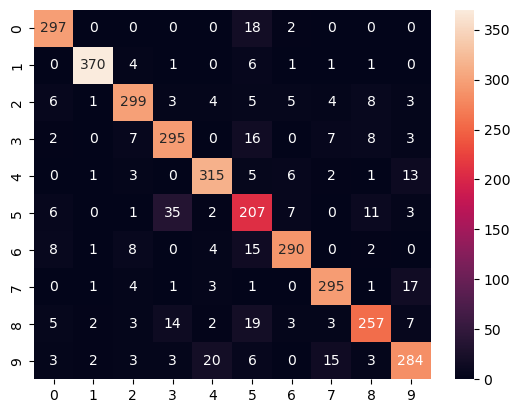

In [133]:
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt='d')

## Considerations


Implementing the RBM and experimenting with various classifiers and their hyperparameters was an enjoyable learning experience. It reinforced the importance of hyperparameter tuning, as they significantly influence model performance, as we've seen in this case. While I anticipated the MLPClassifier to excel, I suspect the limited data hindered its ability to learn optimal weights for effective classification. To explore this further, I might decrease the test set size and observe the impact.

The strong performance of the SVC algorithm on our high-dimensional data was a pleasant surprise. This success suggests including SVC more frequently in my analysis toolbox for similar problems in the future. It would be interesting to investigate how varying the dimensionality of the hidden layers affects SVC's performance.

One potential improvement could involve stacking multiple RBMs to create a deep belief network (DBN). After training the DBN, we could analyze the activation vectors of the hidden layers across all layers. This would help us determine the optimal number of layers needed to achieve the best classification performance.